In [2]:
import datetime
import pytz
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import matplotlib.ticker as mpticker
import pandas
import numpy


In [5]:
from mpl_finance import candlestick_ohlc

import yfinance as yf

In [6]:
yf.pdr_override()


Optimum K is 8
Optimum K is 8
                                   Time    Open    High     Low   Close  \
Datetime                                                                  
2020-09-14 09:30:00-04:00  1.600090e+09  114.72  114.82  114.21  114.23   
2020-09-14 09:31:00-04:00  1.600090e+09  114.22  114.73  113.86  113.98   
2020-09-14 09:34:00-04:00  1.600090e+09  114.13  114.16  113.72  113.78   
2020-09-14 09:35:00-04:00  1.600090e+09  113.91  113.96  113.59  113.60   
2020-09-14 09:36:00-04:00  1.600091e+09  113.60  113.99  113.52  113.95   
2020-09-14 09:37:00-04:00  1.600091e+09  113.94  114.38  113.94  114.19   
2020-09-14 09:38:00-04:00  1.600091e+09  114.22  114.25  114.07  114.12   
2020-09-14 09:39:00-04:00  1.600091e+09  114.12  114.28  113.95  114.23   
2020-09-14 09:40:00-04:00  1.600091e+09  114.22  114.57  114.16  114.56   
2020-09-14 09:41:00-04:00  1.600091e+09  114.56  114.62  114.37  114.60   
2020-09-14 09:42:00-04:00  1.600091e+09  114.60  114.91  114.51  114.8

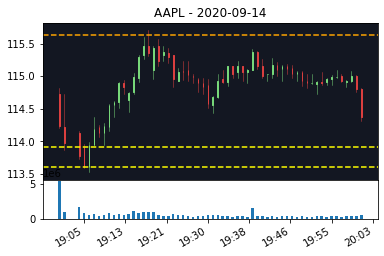

In [38]:
def get_optimum_clusters(df, saturation_point=0.05):
    '''
    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers
    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []

    size = min(11, len(df.index))
    for i in range(1, size):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        k_models.append(kmeans)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    print("Optimum K is " + str(optimum_k + 1))
    optimum_clusters = k_models[optimum_k]

    return optimum_clusters

def plot_stock_data(data):
    fig, ax = plt.subplots()
    ax1 = plt.subplot2grid((5,1), (0,0), rowspan=4)
    ax2 = plt.subplot2grid((5,1), (4,0), sharex=ax1)

    ax1.set_title("{} - {}".format(symbol, start))
    ax1.set_facecolor("#131722")
    ax1.xaxis.set_major_formatter(mpticker.FuncFormatter(mydate))

    candlestick_ohlc(ax1, data.to_numpy(), width=8, colorup='#77d879', colordown='#db3f3f')

    ax2.bar(data['Time'], data['Volume'], width=30)
    ax2.xaxis.set_major_formatter(mpticker.FuncFormatter(mydate))
    fig.subplots_adjust(hspace=0)
    fig.autofmt_xdate()
    return ax1


def mydate(x,pos):
    try:
        return datetime.datetime.fromtimestamp(x, tz=est).strftime(date_format)
    except IndexError:
        return ''


symbol = "AAPL"
start = "2020-09-14"
end = "2020-09-15"
est = pytz.timezone('Asia/Calcutta')
date_format = "%H:%M"

ticker = yf.Ticker(symbol)
data = ticker.history(period="1d", interval="1m",start=start, end=end, prepost=False, actions=False)
data = data[:60] #30 1M candles

data["Time"] = [d.timestamp() for d in data.index]
data.Time = data.Time.tz_convert(est)
data = data[["Time", "Open", "High", "Low", "Close", "Volume"]]

ax = plot_stock_data(data)

lod, hod = 0, 0

lows = pandas.DataFrame(data=data, index=data.index, columns=["Low"])
highs = pandas.DataFrame(data=data, index=data.index, columns=["High"])

low_clusters = get_optimum_clusters(lows)
low_centers = low_clusters.cluster_centers_
low_centers = numpy.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(highs)
high_centers = high_clusters.cluster_centers_
high_centers = numpy.sort(high_centers, axis=0)

print(data)
print("support")
print(low_centers)
print("resistance")
print(high_centers)

for low in low_centers[:2]:
    ax.axhline(low[0], color='yellow', ls='--')

for high in high_centers[-1:]:
    ax.axhline(high[0], color='orange', ls='--')

plt.show()